In [ ]:
f 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install -U encodec
    !pip install torchaudio
    !pip install wandb --upgrade
    # !wandb login
    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews
    !pip install -U ipykernel
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/Jaguas_2018')

elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on colab
/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project


In [ ]:
import numpy as np
from encodec import EncodecModel
from encodec.utils import convert_audio
import torchaudio
import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Jaguas_2018/'

folders = os.listdir(root_path)
files=[]
for i in range(len(folders)):
    path_aux = "{}/{}".format(root_path, folders[i])
    files += list(Path(path_aux).rglob("*.{}".format("wav")))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project


In [ ]:
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)

Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th


  0%|          | 0.00/88.9M [00:00<?, ?B/s]

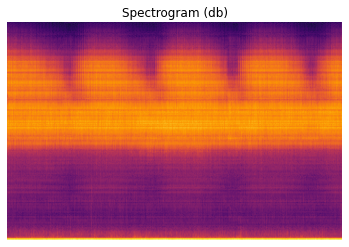

In [ ]:
from Modules.Utils import plot_spectrogram
wav, sr = torchaudio.load(str(files[0]))
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)
wav.shape
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
encodings = torch.reshape(codes,(codes.shape[0], codes.shape[1]*codes.shape[2]))
decodings = torch.reshape(encodings,(encodings.shape[0], 8, 4500))
with torch.no_grad():    
    decoded_frames = model.decode(encoded_frames)

spec_original = torchaudio.transforms.Spectrogram(window_fn=torch.hamming_window,
                                            power=2,
                                            normalized=False)(wav[0])

spec_reconstruction = torchaudio.transforms.Spectrogram(window_fn=torch.hamming_window,
                                            power=2,
                                            normalized=False)(decoded_frames[0])
decodings2 = [(decodings, None)]

final = model.decode(decodings2)
spec_reconstruction = torchaudio.transforms.Spectrogram(window_fn=torch.hamming_window,
                                            power=2,
                                            normalized=False)(final[0])
plot_spectrogram(spec_reconstruction[0].detach().numpy())

In [ ]:
print(decodings2[0][0].shape)
print(type(decodings2[0][0]))
print(encodings.shape)
print(len(decodings2[0][0][0][0]), len(encoded_frames[0][0][0][0]))

torch.Size([1, 8, 4500])
<class 'torch.Tensor'>
torch.Size([1, 36000])
4500 4500


In [ ]:
from torch.utils.data import DataLoader
root = "/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project"
dataset_test = torch.load(f'{root}/temporal/dataset_test_ae_jaguas_new.pth')
dataset_train = torch.load(f'{root}/temporal/dataset_train_ae_jaguas_new.pth')
training_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)
iterator = iter(training_loader)

training_recorder_list = []
training_hour_list = []
training_minute_list = []
delete_samples = []
training_samples_list_torch = torch.ones(6020, 6616).to("cuda")

In [ ]:
for id, item in enumerate(dataset_train):
    # if id == 17:
        # break
    if id% 500 == 0:
        print(f"id: {id + 1} of {len(dataset_train)}")
    spec, wav, label = next(iterator)
    wav = wav.unsqueeze(0)
    with torch.no_grad():
        encoded_frames = model.encode(wav)  
    codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
    encodings = torch.reshape(codes,(codes.shape[0], codes.shape[1]*codes.shape[2]))
    print(encodings.shape)
    training_samples_list_torch[id] = encodings[0]
    training_recorder_list.append(label["recorder"])
    training_hour_list.append(label["hour"])
    training_minute_list.append(label["minute"])

print(f"------------------------------------\n{id}\nProcess finished\nSaving data\n------------------------------------")
# torch.save(training_samples_list_torch, "training_samples_list_torch_encodec.pth")
# torch.save(training_recorder_list, "training_recorder_list_encodec.pth")
# torch.save(training_hour_list, "training_hour_list_encodec.pth")
# torch.save(training_minute_list, "training_minute_list_encodec.pth")
# training_labels_list = {"recorder": training_recorder_list, "hour": training_hour_list, "minute": training_minute_list}
# torch.save(training_labels_list, "training_labels_list_encodec.pth")

id: 1 of 6020
torch.Size([1, 6616])
torch.Size([1, 6616])
torch.Size([1, 6616])
torch.Size([1, 6616])
torch.Size([1, 6616])


KeyboardInterrupt: ignored

In [ ]:
# a,b,c = next(iterator)
# wav=b.unsqueeze(0)
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
encodings = torch.reshape(codes,(codes.shape[0], codes.shape[1]*codes.shape[2]))
with torch.no_grad():    
    decoded_frames = model.decode(encoded_frames)

In [ ]:
spec_original = torchaudio.transforms.Spectrogram(window_fn=torch.hamming_window,
                                            power=2,
                                            normalized=False)(wav[0])

spec_reconstruction = torchaudio.transforms.Spectrogram(window_fn=torch.hamming_window,
                                            power=2,
                                            normalized=False)(decoded_frames[0])

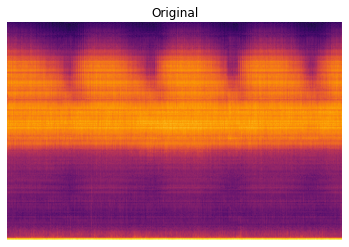

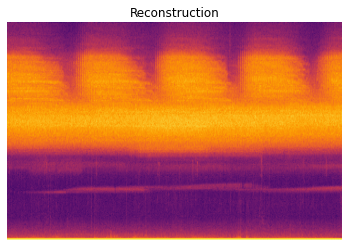

In [ ]:
plot_spectrogram(spec_original[0],  title= "Original")
plot_spectrogram(spec_reconstruction[0], title="Reconstruction")

In [ ]:
from sklearn.preprocessing import StandardScaler
y = torch.load("Features/training_labels_list_encodec.pth",  map_location=torch.device('cpu'))
X = torch.load("Features/training_samples_list_torch_encodec.pth",  map_location=torch.device('cpu'))
X = X[0:6000]
y["recorder"] = y["recorder"][0:6000]

scaler = StandardScaler().fit(X)
from sklearn.manifold import TSNE
X_n = X
X_scaled = scaler.transform(X)
X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_scaled)

## **Traditional clustering**

In [ ]:
# Batch methods
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import matplotlib.cm as cm

# Single methods
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples

In [ ]:
from logging import raiseExceptions
def plot_silhouette( X, cluster_labels, n_clusters, silhouette_avg, method, extra=""):
    fig, ax1 = plt.subplots(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
                    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    print("Ya debio plotear")
    #plt.savefig(f"Clustering_Results/{method}/Figures/Silhouette_plot_{n_clusters}.pdf", format="pdf")
    #plt.show()

def plot_centroids(cluster_centers, method, extra=""):
    plt.figure(figsize=(8, 8))
    for i, spec in enumerate(cluster_centers):
        decodings = np.reshape(spec,(8, 827))
        print(decodings.shape)
        decodings = [(decodings, None)]
        print(type(decodings[0][0]))
        print(decodings[0][0].shape)
        decodings[0][0] = torch.from_numpy(decodings[0][0])
        decodings = model.decode(decodings)
        
        spec_reconstruction = torchaudio.transforms.Spectrogram(window_fn=torch.hamming_window,
                                            power=2,
                                            normalized=False)(decodings[0])
        plot_spectrogram(spec_reconstruction[0].detach().numpy())
        plt.subplot(6, 6, i + 1)
        plt.imshow(decodings[:,:], origin="lower", cmap="viridis")
        plt.xticks(())
        plt.yticks(())
    n_cluster = len(cluster_centers)
    return decodings
    #plt.savefig(f"Clustering_Results/{method}/Figures/Centroids_plot_{n_cluster}_{extra}.pdf", format="pdf")
    #plt.show()

import math

def num_rows_cols(num_elements):
    num_rows = int(math.sqrt(num_elements))
    num_cols = (num_elements + num_rows - 1) // num_rows
    return (num_rows, num_cols)

def get_row_col(pos, cols):
    row = pos // cols
    col = pos % cols
    return row, col

class Clustering_Results:
    def __init__(self, model, y, y_label="hour", hist_library="plt"):
        self._labels_cluster = None
        self._n_labels = None
        self._hist_library = hist_library
        self._label = y_label
        self._model = model
        self._n_clusters = len(set(model.labels_))
        self.y = y
        self._y = self.converter(y[self._label])
        self._n_labels = set(self._y)

    def converter(self, var):
        aux = []
        for i in range(len(var)):
            aux.append(var[i].item())
        return np.array(aux)

    def one_cluster_eval(self, cluster):
        index = np.where(self._model.labels_ == cluster)
        index = list(index[0])
        self._labels_cluster = self._y[index]
        return self._labels_cluster

    def joyplot(self):
        size_x = 8
        size_y = 6
        joy_vars = ["hour", "recorder"]
        for cluster in range(self._n_clusters):
            y_aux = []
            labels_cluster = []
            for i, label in enumerate(joy_vars):
                y_aux.append(self.converter(self.y[label]))
                index = np.where(self._model.labels_ == cluster)
                index = list(index[0])
                labels_cluster.append(y_aux[i][index])
            df = pd.DataFrame({'recorder':labels_cluster[0], "hour":labels_cluster[1]})
            joypy.joyplot(df, by="hour", column="recorder", range_style='own', 
                            grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x,size_y),
                            title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                            colormap=cm.autumn_r, fade=False)
            joypy.joyplot(df, by="recorder", column="hour", range_style='own', 
                                grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x,size_y),
                                title=f"Cluster {cluster} \nLabels distribution along recorders using hours as rows",
                                colormap=cm.autumn_r)
            plt.show()
            


    def histograms(self):
        bins = list(self._n_labels)
        num_rows, num_cols = num_rows_cols(self._n_clusters)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))
        if self._n_clusters <= 3:
                axes = np.expand_dims(axes,0)
                fig.set_figheight(6)
                fig.set_figwidth(12)
                if self._n_clusters == 1:
                    axes = np.expand_dims(axes,0)
                else:
                    pass
        else:
            pass
        for hist in range(self._n_clusters):
            aux = self.one_cluster_eval(hist)
            ax_0, ax_1 = get_row_col(hist, num_cols)
            if self._hist_library == "plt":
                axes[ax_0][ax_1].hist(aux, histtype="bar",
                                      color="paleturquoise", cumulative=False,
                                      edgecolor='black', 
                                      linewidth=1.2, bins=bins, stacked=False)
                axes[ax_0][ax_1].set_title(f"Cluster: {hist}", size=16)
            elif self._hist_library == "sns":
                sns.distplot(aux,bins=np.arange(aux.min(), aux.max()+1),
                             hist_kws=dict(edgecolor="black", linewidth=1), 
                             ax=axes[ax_0, ax_1])
                axes[ax_0][ax_1].set_title(f"Cluster: {hist}", size=16)              
            else:
                raise Exception(f"Library {self._hist_library} unused")
        plt.show()

In [ ]:
prueba = torch.rand(1, 6616)
print(prueba.shape)
decodings = plot_centroids(prueba,"Kmeans")

torch.Size([1, 6616])
torch.Size([8, 827])
<class 'list'>


RuntimeError: ignored

<Figure size 800x800 with 0 Axes>

In [ ]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
mean = X.mean()
std = X.std()
silhouette_score_Kmeans = []
# X_normalized = 
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_scaled)
    # silhouette_score_Kmeans.append(metrics.silhouette_score(X_scaled, Kmeans.labels_))
    # plot_silhouette(X_scaled, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id], "Kmeans")
    cluster_centers = scaler.inverse_transform(Kmeans.cluster_centers_)
    print(cluster_centers.shape)
    plot_centroids(cluster_centers, "Kmeans")
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()
    Kmeans_Results.joyplot()
with open(f"Clustering_Results/Kmeans/Results/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(silhouette_score_Kmeans, file)

(2, 6616)
(8, 827)
<class 'numpy.ndarray'>
(8, 827)


TypeError: ignored

<Figure size 576x576 with 0 Axes>

In [ ]:
!pip install joypy
import joypy
import pickle as pkl
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
Kmeans = KMeans(n_clusters=8, random_state=0).fit(X_scaled)
import warnings
warnings.filterwarnings("ignore")
Kmeans_Results = Clustering_Results(Kmeans, y, y_label="recorder", hist_library="plt")
Kmeans_Results.joyplot()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


NameError: ignored

In [ ]:
def converter(var):
        aux = []
        for i in range(len(var)):
            aux.append(var[i].item())
        return np.array(aux)
y_n = converter(y["hour"])[0:6000]
y_n

array([10, 10,  3, ..., 19, 22, 10])

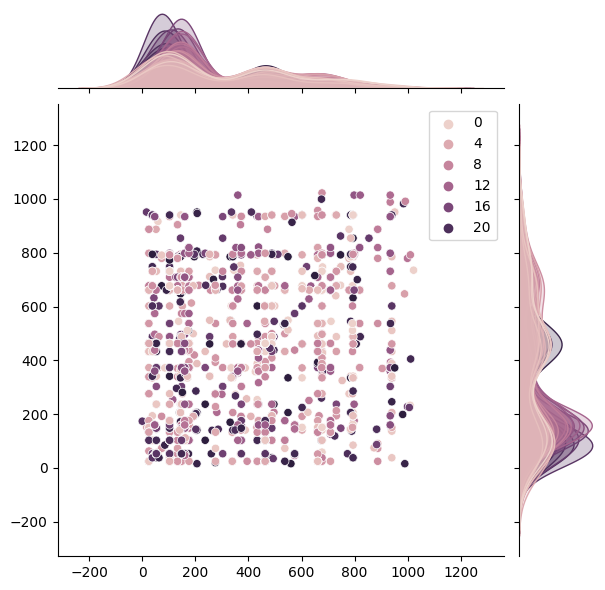

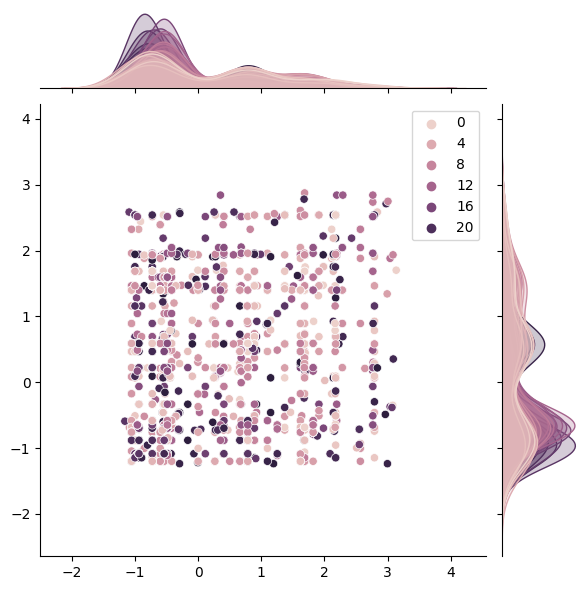

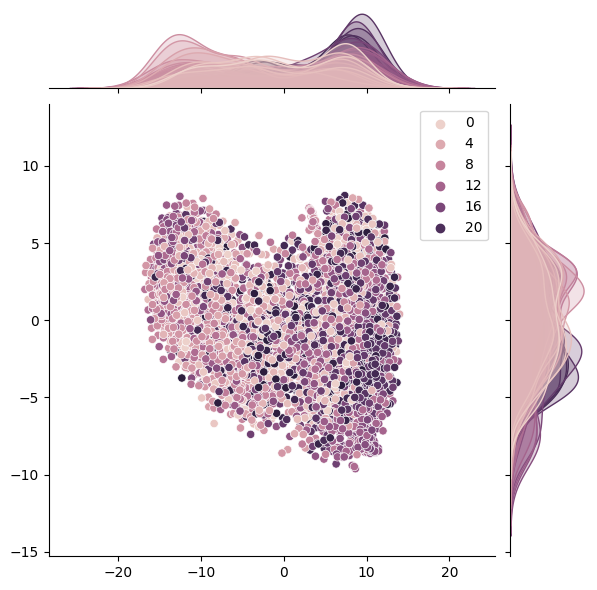

In [ ]:
X_n = X.numpy()
X_ = [X_n, X_scaled, X_TSNE]
# fig, axes = plt.subplots(1, 3, figsize=(16, 6))
for enum, x in enumerate(X_):
    sns.jointplot(x=X_[enum][:,0], y= X_[enum][:,1], hue=y_n[0:6000]) 

## Kmeans